In [53]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import string
import contractions
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

# utils
import os
from tqdm import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## EDA

In [16]:
# read data
data = pd.read_csv('../data/imdb.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [17]:
def transform_label(label):
    return 1 if label == 'positive' else -1

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 327732.23it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,-1
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [18]:
data.sentiment.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [29]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:03<00:00, 15998.52it/s]


In [30]:
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

In [31]:
data_neg = data[data['label'] == -1]
data_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

<Figure size 360x576 with 0 Axes>

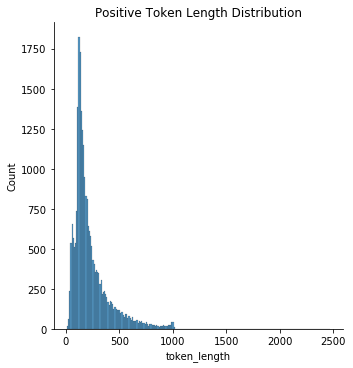

In [26]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 360x576 with 0 Axes>

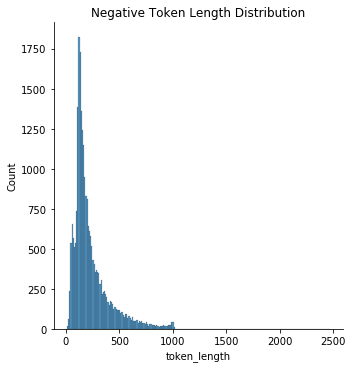

In [27]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Negative Token Length Distribution')
plt.show()

In [47]:
# see most minimum length token
print('Positive')
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['review'].item())
print()
print('Negative')
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['review'].item())

Positive
Brilliant and moving performances by Tom Courtenay and Peter Finch.

Negative
Primary plot!Primary direction!Poor interpretation.


## Clean and Preprocess

In [55]:
# text cleaning

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)
    # return re.sub(r"https?://\S+|www\.\S+", "", text)

def rm_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub('', re.compile(r'<[^>]+>'))

def space_bt_punct(text):
    
    return

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):    
    no_link = rm_link(text)
    no_punct = rm_punct2(no_link)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [56]:
# preprocessing
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def postag(text):
    # not implemented yet
    return

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [51]:
data['clean'] = data['review'].progress_apply(clean_pipeline)
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)
data.head()

100%|██████████| 50000/50000 [03:24<00:00, 245.04it/s]


,review,sentiment,label,token_length,clean,processed
0,One of the other reviewers has mentioned that ...,positive,1,307,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,162,A wonderful little production br br The filmin...,A wonderful little production br br The filmin...
2,I thought this was a wonderful way to spend ti...,positive,1,166,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,-1,138,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...


## Prepare Dataset
